# Age regression from brain MRI

Predicting the age of a patient from their brain MRI scan can have diagnostic value for a number of diseases that may cause structural changes and potential damage to the brain. A discrepancy between the predicted age and the real, chronological age of a patient might indicate the presence of disease. This requires an accurate predictor of brain age which may be learned from a set of healthy reference subjects, given their brain MRI data and their actual age.

**The objective is to implement two supervised learning approaches for age regression from brain MRI.** Using data from 652 healthy subjects, that is split into different development sets and a hold-out test set on which we evaluate the final prediction accuracy.

This Notebook is based on the coursework for the Machine Learning for Imaging course at Imperial College London. Full Credits to Ugo Benassayag, Hugo Zylberajch and Nasma Dasser. 

### Getting started and familiarise ourselves with the data

The following cells provide some helper functions to load the data, and provide some overview and visualisation of the statistics over the total population of 652 subjects. The data will be split into different subsets to be used for different parts of the coursework. There is a set of 52 subjects to be used in part A to develop an image segmentation method (47 for training, 5 for validation). We then use 500 subjects for training and two-fold cross-validation of age regression approaches in part A and B. **A remaining set of 100 subjects is used to test the final age prediction accuracy and will be made available towards the end of the coursework.**

### Install SimpleITK

In [1]:
from google.colab import drive
drive.mount('/content/drive')
! pip install SimpleITK==1.2.4 

Mounted at /content/drive
     |████████████████████████████████| 42.5MB 70kB/s 


### Downloading the data

In [ ]:
! wget -q --show-progress https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-data.zip
! unzip brainage-data.zip

### Setting data directory

In [3]:
# data directory
data_dir = 'data/brain_age/'

Let's start by loading the meta data of the entire population, that is the data containing information about the subject IDs, their age, and gender.

In [4]:
# Read the meta data using pandas
import pandas as pd

meta_data_all = pd.read_csv(data_dir + 'meta/meta_data_all.csv')
meta_data_all.head() # show the first five data entries

,subject_id,age,gender_code,gender_text
0,CC110033,24,1,MALE
1,CC110037,18,1,MALE
2,CC110045,24,2,FEMALE
3,CC110056,22,2,FEMALE
4,CC110062,20,1,MALE


Let's have a look at some population statistics.

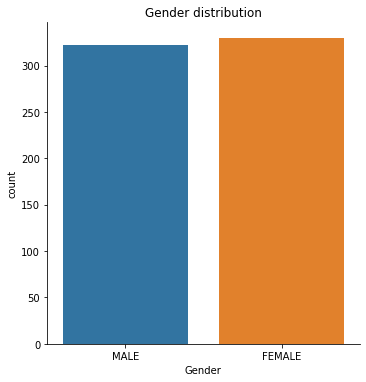

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


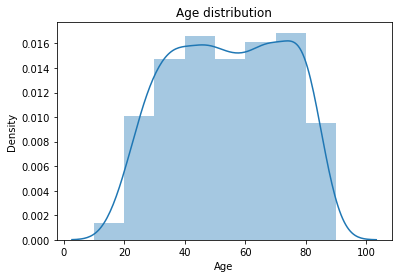

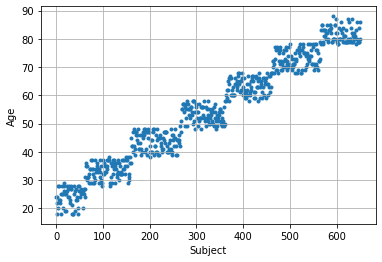

In [25]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
from utils.utils_plots import display_statistics
display_statistics (meta_data_all)


### Set up a simple medical image viewer and import SimpleITK

In [8]:
import SimpleITK as sitk
from utils.mri_visualisation import display_image, interactive_view

### Imaging data

Let's check out the imaging data that is available for each subject. This cell also shows how to retrieve data given a particular subject ID from the meta data.

Imaging data of subject CC110033 with age 24

MR Image


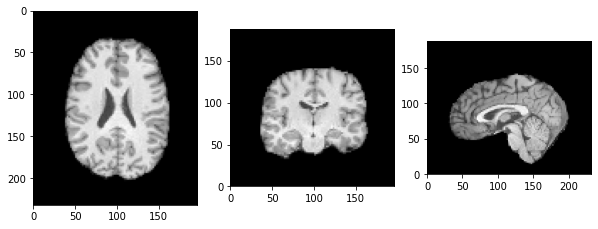

Brain mask


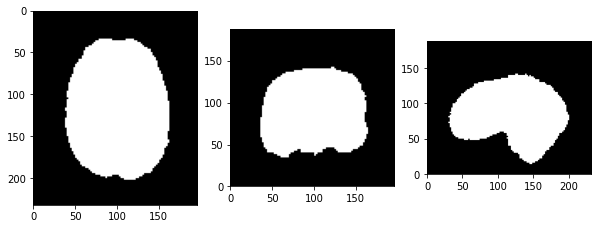

In [9]:
# Subject with index 0
ID = meta_data['subject_id'][0]
age = meta_data['age'][0]

# Image
image_filename = data_dir + 'images/sub-' + ID + '_T1w_unbiased.nii.gz'
img = sitk.ReadImage(image_filename)

# Mask
mask_filename = data_dir + 'masks/sub-' + ID + '_T1w_brain_mask.nii.gz'
msk = sitk.ReadImage(mask_filename)

print('Imaging data of subject ' + ID + ' with age ' + str(age))

print('\nMR Image')
display_image(img, window=400, level=200)

print('Brain mask')
display_image(msk)

## Part A: Age prediction using brain tissue segmentation and volume features

The first approach aims to regress the age of a subject using the volumes of brain tissues as features. The brain tissues include grey matter (GM), white matter (WM), and cerebrospinal fluid (CSF). It is known that with increasing age the ventricles enlarge (filled with CSF), while it is assumed that grey and white matter volume may decrease over time. However, as overall brain volume varies across individuals, taking the absolute volumes of tissues might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. To this end, a four-class (GM, WM, CSF, and background) brain segmentation needs to be implemented which will be trained using a total of 52 subjects (47 for training, 5 for validation). The segmentation method is then applied to the remaining 600 brain scans which will be used to train and test the age regression. Brain masks are provided which have been generated with a state-of-the-art neuroimaging brain extraction tool.

Different regression techniques should be explored, and it might be beneficial to investigate what the best set of features is for this task. Are all volume features equally useful, or is it even better to combine some of them and create new features. How does a simple linear regression perform compared to a model with higher order polynomials? Do you need regularisation? How about other regression methods such as regression trees, SVMs or neural networks? The accuracy of different methods should be evaluated using two-fold cross-validation on the set of 500 subjects, and average age prediction accuracy should be compared and reported appropriately. The final prediction accuracy will be evaluated on a hold-out set of 100 subjects.



### TASK A-1: Brain tissue segmentation

Implement a CNN model for brain tissue segmentation which can provide segmentations of GM, WM, and CSF. For this task (and only for this task), we provide a subset of 52 subjects which are split into 47 images for training and 5 for validation. The template code below has the data handling and main training routines already implemented, so you can focus on implementing a suitable CNN model. A simple model is provided, but this won't perform very well.

Once your model is trained and you are happy with the results on the validation data you should apply it to the 500 subjects later used for training the age regressor. We provide reference segmentations in a subfolder `segs_refs` for all subjects. Calculate Dice similarity coefficients per tissue when comparing your predicted segmentations to the reference segmentations. Summarise the statistics of the 500 Dice scores for each tissue class in [box-and-whisker-plots](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.boxplot.html).


#### Imports

In [10]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

#### Data Helpers

In [11]:
from utils.data_helpers import ImageSegmentationDataset

#### Check that the GPU is up and running

In [12]:
cuda_dev = '0' #GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev))))        

Device: cuda:0
GPU: Tesla T4


#### Config and hyper-parameters

Here we set some default hyper-parameters and a starting configuration for the image resolution and others.

In [13]:
rnd_seed = 42 #fixed random seed

img_size = [64, 64, 64]
img_spacing = [3, 3, 3]

num_epochs = 20
learning_rate = 0.001
batch_size = 2
val_interval = 5 # changed from 10

num_classes = 4

out_dir = './output'

# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [14]:
## HIGHER RESOLUTION ALTERNATIVE

img_size_HR = [128, 128, 128]
img_spacing_HR = [1.5, 1.5, 1.5]


#### Loading and pre-processing of training and validation data

In [15]:
meta_data_seg_train = pd.read_csv(data_dir + 'meta/meta_data_segmentation_train.csv')
ids_seg_train = list(meta_data_seg_train['subject_id'])
files_seg_img_train = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_train]
files_seg_seg_train = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_train]
files_seg_msk_train = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_train]

meta_data_seg_val = pd.read_csv(data_dir + 'meta/meta_data_segmentation_val.csv')
ids_seg_val = list(meta_data_seg_val['subject_id'])
files_seg_img_val = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_val]
files_seg_seg_val = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_val]
files_seg_msk_val = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_val]

We apply some standard pre-processing on the data such as intensity normalization (zero mean unit variance) and downsampling according to the configuration above.

**You may want to use initially the validation data with 5 subjects for training which is more efficient when debugging your training routine and model implementation. Make sure to later train your final model on the actual training data.**

In [16]:
# LOAD TRAINING DATA
dataset_train = ImageSegmentationDataset(files_seg_img_train, files_seg_seg_train, files_seg_msk_train, img_spacing, img_size)
# FOR QUICK DEBUGGING, USE THE VALIDATION DATA FOR TRAINING
#dataset_train = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# LOAD VALIDATION DATA
dataset_val = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 5/5 [00:00<00:00,  5.68it/s]


In [ ]:
## HIGHER RESOLUTION ALTERNATIVE
# LOAD TRAINING DATA
dataset_train_HR = ImageSegmentationDataset(files_seg_img_train, files_seg_seg_train, files_seg_msk_train, img_spacing_HR, img_size_HR)
# FOR QUICK DEBUGGING, USE THE VALIDATION DATA FOR TRAINING
#dataset_train = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing, img_size)
dataloader_train_HR = torch.utils.data.DataLoader(dataset_train_HR, batch_size=batch_size, shuffle=True)

# LOAD VALIDATION DATA
dataset_val_HR = ImageSegmentationDataset(files_seg_img_val, files_seg_seg_val, files_seg_msk_val, img_spacing_HR, img_size_HR)
dataloader_val_HR = torch.utils.data.DataLoader(dataset_val_HR, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


#### Visualise training example

Just to check how a training image looks like after pre-processing.

Image: sub-CC221040_T1w_unbiased.nii.gz


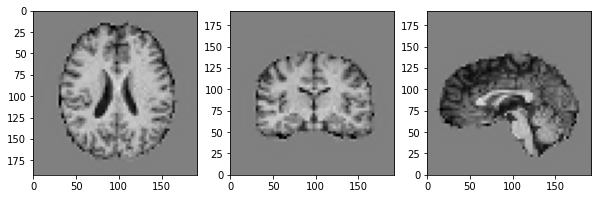

Segmentation


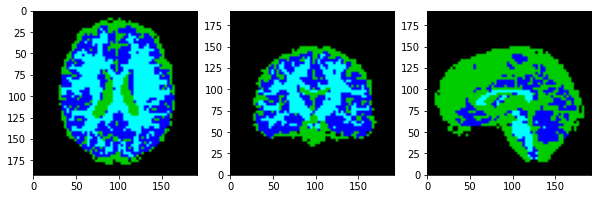

Mask


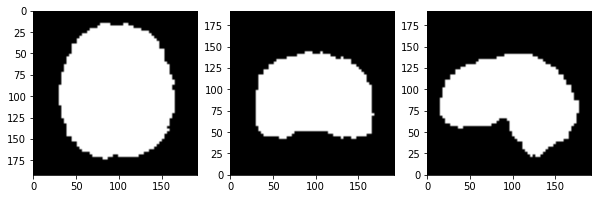

In [17]:
sample = dataset_train.get_sample(0)
img_name = dataset_train.get_img_name(0)
seg_name = dataset_train.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

Image: sub-CC221040_T1w_unbiased.nii.gz


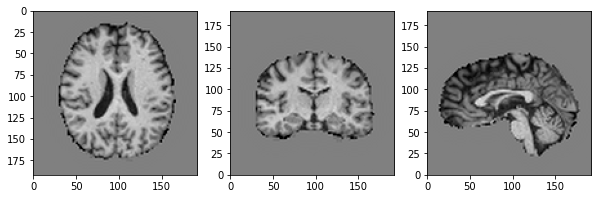

Segmentation


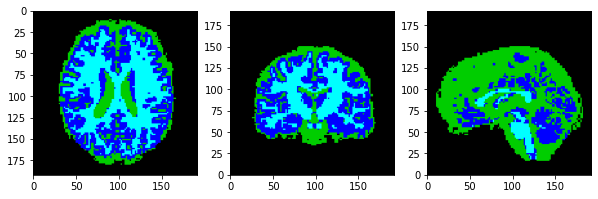

Mask


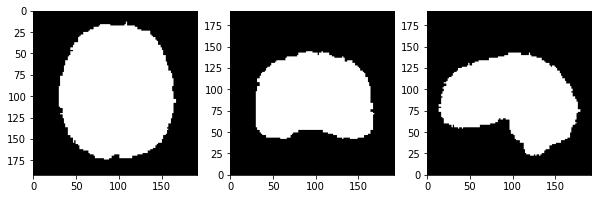

In [ ]:
## HIGHER RESOLUTION ALTERNATIVE
sample_HR = dataset_train_HR.get_sample(0)
img_name_HR = dataset_train_HR.get_img_name(0)
seg_name_HR = dataset_train_HR.get_seg_name(0)
print('Image: ' + img_name_HR)
display_image(sample_HR['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample_HR['seg']))
print('Mask')
display_image(sample_HR['msk'])

In [ ]:
# data check
meta_data.head()

,subject_id,age,gender_code,gender_text
0,CC110033,24,1,MALE
1,CC110037,18,1,MALE
2,CC110045,24,2,FEMALE
3,CC110056,22,2,FEMALE
4,CC110062,20,1,MALE


In [ ]:
meta_data[meta_data['subject_id'] == 'CC110033'].age.values

array([24])

36
Image: sub-CC221040_T1w_unbiased.nii.gz


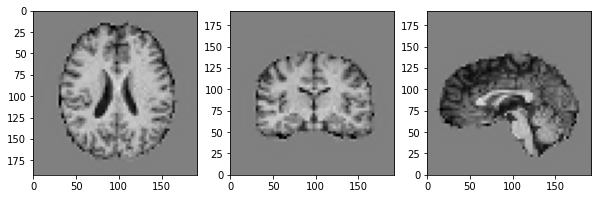

29
Image: sub-CC221373_T1w_unbiased.nii.gz


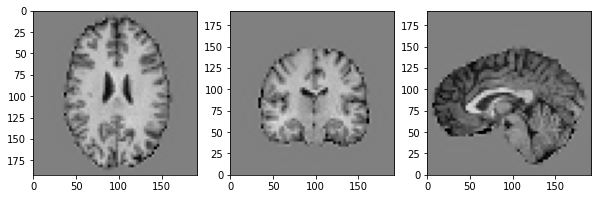

64
Image: sub-CC520391_T1w_unbiased.nii.gz


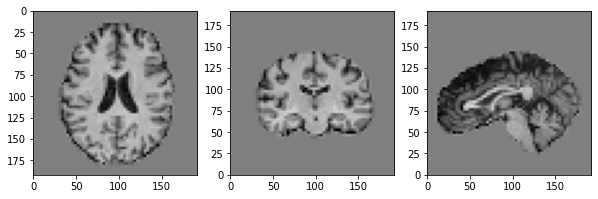

81
Image: sub-CC710313_T1w_unbiased.nii.gz


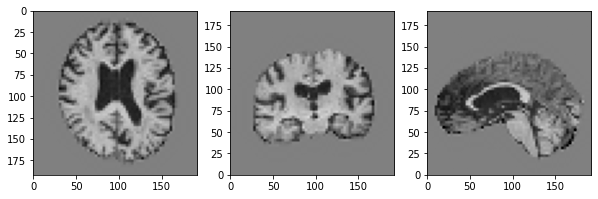

47
Image: sub-CC320893_T1w_unbiased.nii.gz


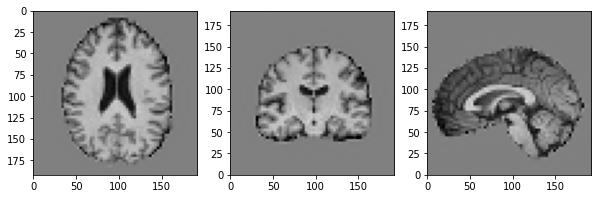

In [ ]:
# Display five samples for visualisation
for i in range(5):
  sample = dataset_train.get_sample(i)
  img_name = dataset_train.get_img_name(i)
  print(meta_data[meta_data['subject_id'] == img_name.split('_')[0][4:]].age.values[0])
  print('Image: ' + img_name)
  display_image(sample['img'], window=5, level=0)

#### The Model

Design a suitable CNN model for brain segmentation.

In [19]:
# import the 3d UNet designed for the task
from UNet3d import UNet3D
from utils.dice_score import dice_score


#### TRAINING

Below is an implementation of a full training procedure including a loop for intermediate evaluation of the model on the validation data. Feel free to modify this procedure. For example, in addition to the loss you may want to monitor Dice scores (or others).

START TRAINING...
+ TRAINING 	Epoch: 1 	Loss: 0.162625
--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 0.459355 	 DICE:[0.9295969  0.12270158 0.44012596 0.81795027]


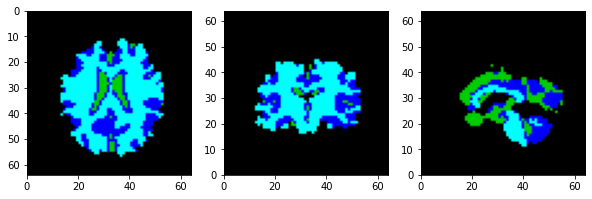

--------------------------------------------------
+ TRAINING 	Epoch: 2 	Loss: 0.146776
+ TRAINING 	Epoch: 3 	Loss: 0.117999
+ TRAINING 	Epoch: 4 	Loss: 0.108637
+ TRAINING 	Epoch: 5 	Loss: 0.121159
--------------------------------------------------
+ VALIDATE 	Epoch: 5 	Loss: 0.111113 	 DICE:[0.98957841 0.75205387 0.85277566 0.89475452]


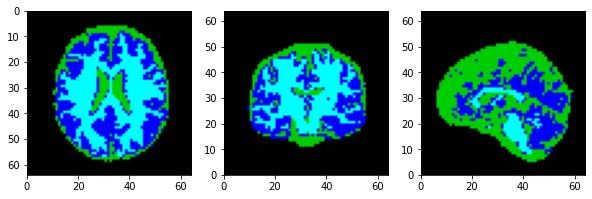

--------------------------------------------------
+ TRAINING 	Epoch: 6 	Loss: 0.098241
+ TRAINING 	Epoch: 7 	Loss: 0.091552
+ TRAINING 	Epoch: 8 	Loss: 0.095127
+ TRAINING 	Epoch: 9 	Loss: 0.081696
+ TRAINING 	Epoch: 10 	Loss: 0.119592
--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 0.102841 	 DICE:[0.98870013 0.76110764 0.86559668 0.9072947 ]


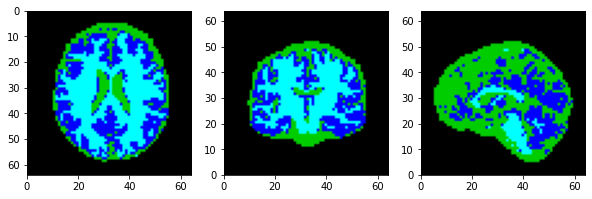

--------------------------------------------------
+ TRAINING 	Epoch: 11 	Loss: 0.096582
+ TRAINING 	Epoch: 12 	Loss: 0.097314
+ TRAINING 	Epoch: 13 	Loss: 0.091262
+ TRAINING 	Epoch: 14 	Loss: 0.102613
+ TRAINING 	Epoch: 15 	Loss: 0.072295
--------------------------------------------------
+ VALIDATE 	Epoch: 15 	Loss: 0.093396 	 DICE:[0.98995527 0.74083563 0.87944556 0.91766121]


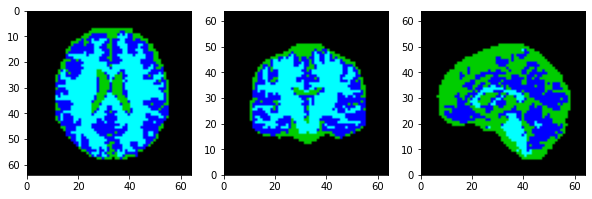

--------------------------------------------------
+ TRAINING 	Epoch: 16 	Loss: 0.088518
+ TRAINING 	Epoch: 17 	Loss: 0.103922
+ TRAINING 	Epoch: 18 	Loss: 0.089356
+ TRAINING 	Epoch: 19 	Loss: 0.090349
+ TRAINING 	Epoch: 20 	Loss: 0.086107
--------------------------------------------------
+ VALIDATE 	Epoch: 20 	Loss: 0.085447 	 DICE:[0.9914449  0.78851229 0.88181437 0.91529765]


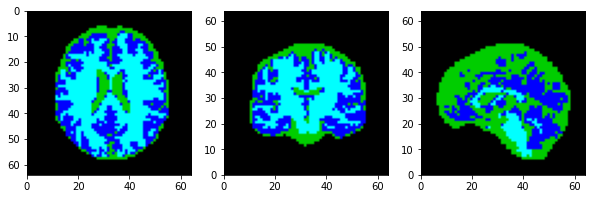

--------------------------------------------------

Finished TRAINING.


In [22]:
# we added Dice scores
import numpy as np
model_dir = os.path.join(out_dir, 'model')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.manual_seed(rnd_seed) #fix random seed

model = UNet3D().to(device)
    
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_train_log = []
dice_train_log = []
loss_val_log = []
bg_dice_log = []
gm_dice_log = []
wm_dice_log = []
csf_dice_log = []
epoch_val_log = []
    
print('START TRAINING...')
for epoch in range(1, num_epochs + 1):
    model.train()

    # Training
    for batch_idx, batch_samples in enumerate(dataloader_train):
        img, seg = batch_samples['img'].to(device), batch_samples['seg'].to(device)
        optimizer.zero_grad()
        prd = model(img)
        loss = F.cross_entropy(prd, seg.squeeze(1))
        loss.backward()
        optimizer.step()

    loss_train_log.append(loss.item())

    print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))
    model.eval()

    # Validation
    if epoch == 1 or epoch % val_interval == 0:
        loss_val = 0
        sum_pts = 0
        dice_val = np.zeros(num_classes)
        with torch.no_grad():
            for data_sample in dataloader_val:
                img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
                prd = model(img)
                loss_val += F.cross_entropy(prd, seg.squeeze(1), reduction='sum').item()
                dice_val += dice_score(torch.argmax(prd, dim=1),seg, num_classes)
                sum_pts += np.prod(img_size)
                
                
        prd = torch.argmax(prd, dim=1)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        

        loss_val /= sum_pts
        dice_val /= len(dataloader_val)

        loss_val_log.append(loss_val)
        bg_dice_log.append(dice_val[0])
        csf_dice_log.append(dice_val[1])
        gm_dice_log.append(dice_val[2])
        wm_dice_log.append(dice_val[3])


        epoch_val_log.append(epoch)

        print('--------------------------------------------------')
        print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f} \t DICE:{}'.format(epoch, loss_val,dice_val))
        display_image(sitk.LabelToRGB(prediction))
        print('--------------------------------------------------')

torch.save(model.state_dict(), os.path.join(model_dir, 'model.pt'))

print('\nFinished TRAINING.')


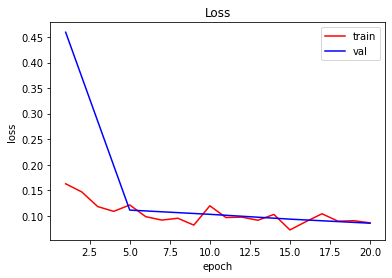

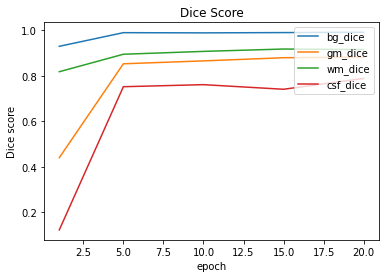

In [23]:
# plot the loss 
from utils.utils_plots import plot_loss_vs_scores

plot_loss_vs_scores(num_epochs, 
                        loss_train_log, epoch_val_log, loss_val_log, 
                        bg_dice_log, gm_dice_log, wm_dice_log, csf_dice_log)

#### Loading and pre-processing of testing data

Now that we have trained a model, the next cells are about applying that model to the 500 subjects that are used for training the age regressor. Note, at a later stage you will also need to run the model on the 100 subjects from the hold-out set, once these have been made available. Before testing on the full set, you may want to initially just test on the 5 validation subjects to check everything is working fine.

In [24]:
meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_seg_test = list(meta_data_reg_train['subject_id'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

dataset_test = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 500/500 [01:26<00:00,  5.76it/s]


#### Visualise testing example

Just to check how a testing image looks like after pre-processing.

Image: sub-CC520745_T1w_unbiased.nii.gz


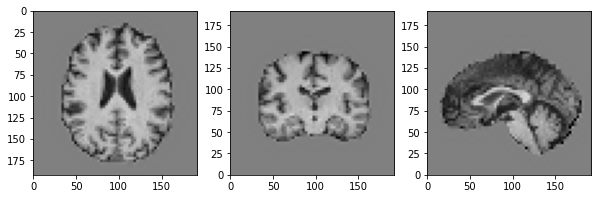

Segmentation


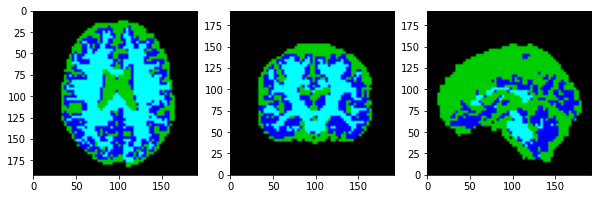

Mask


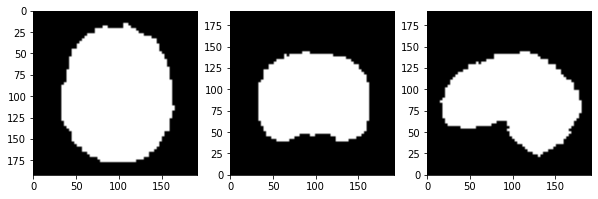

In [ ]:
sample = dataset_test.get_sample(0)
img_name = dataset_test.get_img_name(0)
seg_name = dataset_test.get_seg_name(0)
print('Image: ' + img_name)
display_image(sample['img'], window=5, level=0)
print('Segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Mask')
display_image(sample['msk'])

#### TESTING

Below is an implementation of a full testing procedure that saves the segmentations in an output folder. Feel free to modify this procedure.

**TASK: You will need to add the calculations of Dice scores (and possibly other metrics) to evaluate the segmentation performance.**

Predicting on test data:   0%|          | 0/500 [00:00<?, ?it/s]

START TESTING...


Predicting on test data: 100%|██████████| 500/500 [01:32<00:00,  5.41it/s]


+ TESTING 	Loss: 0.098508


Reference segmentation


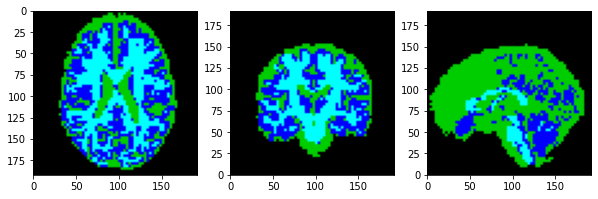

Predicted segmentation


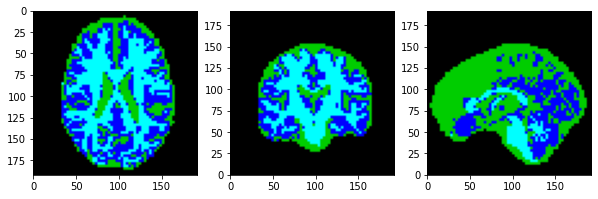


Finished TESTING.


In [27]:
pred_dir = os.path.join(out_dir, 'pred')
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

model = UNet3D()
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
model.to(device)
model.eval()
    
print('START TESTING...')

loss_test = 0
sum_pts = 0
idx_test = 0
dice_test = np.zeros((len(dataloader_test),num_classes))
with torch.no_grad():
    for data_sample in tqdm(dataloader_test,desc='Predicting on test data'):
        img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
        prd = model(img)
        loss_test += F.cross_entropy(prd, seg.squeeze(1), reduction='sum').item()
        sum_pts += np.prod(img_size)
        
        prd = torch.argmax(prd, dim=1)

        sample = dataset_test.get_sample(idx_test)
        name = dataset_test.get_seg_name(idx_test)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        prediction.CopyInformation(sample['seg'])
        sitk.WriteImage(prediction, os.path.join(pred_dir, name))
        dice_test[idx_test] = dice_score(prd,seg,num_classes)
        idx_test += 1
        
loss_test /= sum_pts

print('+ TESTING \tLoss: {:.6f}'.format(loss_test))

# Show last testing sample as an example
print('\n\nReference segmentation')
display_image(sitk.LabelToRGB(sample['seg']))
print('Predicted segmentation')
display_image(sitk.LabelToRGB(prediction))

print('\nFinished TESTING.')

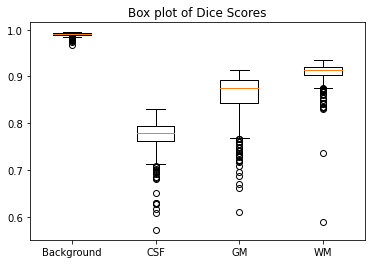

In [28]:
fig1, ax1 = plt.subplots()
ax1.set_title('Box plot of Dice Scores')
dic = ax1.boxplot(dice_test,labels=["Background","CSF","GM","WM"])

### TASK A-2: Feature calculation

Calculate the three absolute tissue volumes for each subject. Plot the volumes against the subjects' ages. Taking the absolute volumes of tissues as features, however, might not be predictive. Instead, relative volumes need to be computed as the ratios between each tissue volume and overall brain volume. But you might also want to explore using different combinations or even polynomial features.

Implement a function that constructs a big matrix $X$ with a row for each subject and features across the columns. Start with just calculating three simple features of relative tissue volumes for GM, WM and CSF, and compare these to the absolute volumes plotted above.


In [29]:
## CALCULATE ABSOLUTE TISSUE VOLUMES

import os

# USE THIS TO RUN THE CALCULATIONS ON YOUR SEGMENTATONS
seg_dir = os.path.join(out_dir, 'pred/')

# USE THIS TO RUN THE CALCULATIONS ON OUR REFERENCE SEGMENTATIONS
#seg_dir = data_dir + 'segs_refs/'

meta_data_reg_train = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_reg_train = list(meta_data_reg_train['subject_id'])
files_reg_seg_train = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_train]

# THIS MATRIX WILL STORE THE VOLUMES PER TISSUE CLASS
vols = np.zeros((3,len(files_reg_seg_train)))

for idx, _ in enumerate(tqdm(range(len(files_reg_seg_train)), desc='Computing Features')):
    
    seg_filename = files_reg_seg_train[idx]
    
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)
        seg_array = sitk.GetArrayFromImage(seg)
        for i in range(3):
            vols[i][idx] = np.sum(seg_array[seg_array==(i+1)]==i+1)

Computing Features: 100%|██████████| 500/500 [00:01<00:00, 405.76it/s]


Plot features versus age.

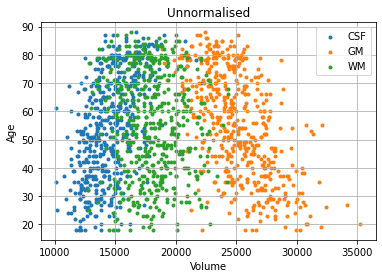

In [30]:
from utils.utils_plots import plot_volume_vs_age
plot_volume_vs_age(vols, meta_data_reg_train, title='Unnormalised')

In [32]:
## CALCULATE RELATIVE TISSUE VOLUMES

vols_normalised = np.zeros((3,len(files_reg_seg_train)))
for idx in range(len(files_reg_seg_train)):
    brain_volume = np.sum(vols[:,idx])
    vols_normalised[:,idx] = vols[:,idx]/brain_volume

Plot normalised features versus age.

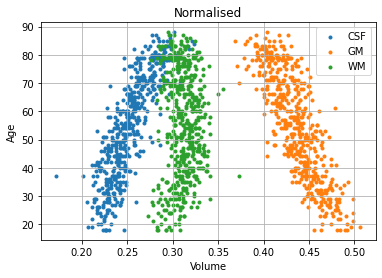

In [33]:
plot_volume_vs_age(vols_normalised, meta_data_reg_train, title='Normalised')

Final data for age regression

In [35]:
X = vols_normalised.T
y = meta_data_reg_train['age'].values.reshape(-1,1)

print(X.shape)
print(y.shape)

(500, 3)
(500, 1)


### TASK A-3: Age regression and cross-validation

Experiment with different regression methods from the [scikit-learn toolkit](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning). Construct the output vector $y$ containing the age for each of the subjects.

Evaluate the methods using two-fold [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) where the dataset of 500 subjects is split into two equally sized sets $(X_1,y_1)$ and $(X_2,y_2)$ which are used for training and testing in an alternating way (so each set is used as $(X_{\text{train}},y_{\text{train}})$ and $(X_{\text{test}},y_{\text{test}})$ exactly once).


Error calculation and plotting

In [36]:
### Cross Validation

from sklearn.linear_model import LinearRegression, BayesianRidge, LassoLars
from sklearn.metrics import *
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

regs = {
    'LinearRegression' : LinearRegression(),
    'BayesianRidge' : BayesianRidge(),
    'Polynomial (deg 3)' : Pipeline([('poly', PolynomialFeatures(degree=3)),
                   ('linear', LinearRegression(fit_intercept=False))])
}

error_metrics = {
    'explained_variance_score' : explained_variance_score, 
    'mean_absolute_error' : mean_absolute_error, 
    'mean_squared_error' : mean_squared_error, 
    'mean_squared_log_error' : mean_squared_log_error,
    'median_absolute_error' : median_absolute_error,
    'r2_score' : r2_score,
}

nb_regs = len(regs)
nb_errs = len(error_metrics)

# A matrix containg errros for each regressor
errors = np.zeros(shape=(nb_regs, nb_errs))

# Lists containg predicted vs actual ages
Kfolds_ypreds = []
Kfolds_ytest = []

# Perform 2-folds cross validation
k = 2
kf = KFold(n_splits=k, shuffle=True)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # regression methods
    y_preds = []
    for reg in regs.values():
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        y_pred = y_pred.reshape(X_train.shape[0],)
        y_preds.append(y_pred)
    # error metrics
    for i in range(nb_regs):
        for j in range(nb_errs):
            errors[i][j] += list(error_metrics.values())[j](y_test, y_preds[i])

    Kfolds_ypreds.append(y_preds)
    Kfolds_ytest.append(y_test)


errors /= k
for i, regname in enumerate(regs.keys()):
    print('Reporting errors for the linear regression model: ' + regname)
    reg = list(regs.values())[i]
    reg_errors = errors[i]
    
    # Reporting error according to each metric
    for j, e in enumerate(error_metrics):
        print('{}: {}'.format(e, reg_errors[j]))
    print()


Kfolds_ypreds = np.array(Kfolds_ypreds)
Kfolds_ytest = np.array(Kfolds_ytest)
y_preds = np.concatenate((Kfolds_ypreds[0], Kfolds_ypreds[1]), axis=1)
y_tests = np.concatenate((Kfolds_ytest[0], Kfolds_ytest[1]), axis=0)
y_tests = y_tests.reshape(y_tests.shape[0],)


Reporting errors for the linear regression model: LinearRegression
explained_variance_score: 0.7359761806100236
mean_absolute_error: 7.563330078125
mean_squared_error: 90.1062299747467
mean_squared_log_error: 0.04014370119784669
median_absolute_error: 6.325439453125
r2_score: 0.7354515727370111

Reporting errors for the linear regression model: BayesianRidge
explained_variance_score: 0.7359296324357764
mean_absolute_error: 7.566727850009126
mean_squared_error: 90.06590465351266
mean_squared_log_error: 0.04008483869749781
median_absolute_error: 6.356827884041092
r2_score: 0.7355666361630567

Reporting errors for the linear regression model: Polynomial (deg 3)
explained_variance_score: 0.7496036549860985
mean_absolute_error: 7.1082028698396424
mean_squared_error: 85.62099171108704
mean_squared_log_error: 0.03753446075873694
median_absolute_error: 5.697120788999484
r2_score: 0.7487700011884403



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Text(0.5, 1.0, 'Polynomial (deg 3)')

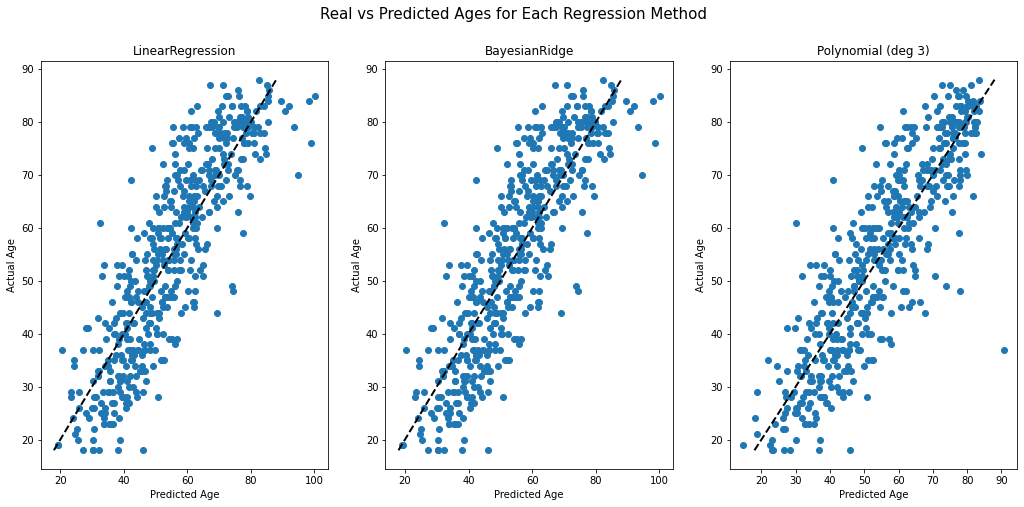

In [37]:

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17.5, 7.5))
f.suptitle('Real vs Predicted Ages for Each Regression Method', fontsize=15)

ax1.scatter(y_preds[0], y_tests)
ax1.plot([y_tests.min(), y_tests.max()], [y_tests.min(), y_tests.max()], 'k--', lw=2)

ax2.scatter(y_preds[1], y_tests)
ax2.plot([y_tests.min(), y_tests.max()], [y_tests.min(), y_tests.max()], 'k--', lw=2)

ax3.scatter(y_preds[2], y_tests)
ax3.plot([y_tests.min(), y_tests.max()], [y_tests.min(), y_tests.max()], 'k--', lw=2)

ax1.set_xlabel('Predicted Age')
ax2.set_xlabel('Predicted Age')
ax3.set_xlabel('Predicted Age')

ax1.set_ylabel('Actual Age')
ax2.set_ylabel('Actual Age')
ax3.set_ylabel('Actual Age')

regnames = list(regs.keys())
ax1.set_title(regnames[0])
ax2.set_title(regnames[1])
ax3.set_title(regnames[2])

MAE: 7.073625
R2: 0.76166857098789


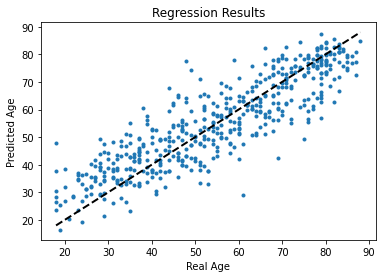

In [ ]:

regressor = Pipeline([('poly', PolynomialFeatures(degree=3)),
                   ('linear', LinearRegression(fit_intercept=False))])

regressor.fit(X,y)
predicted = regressor.predict(X)

print('MAE: {0}'.format(mean_absolute_error(y,predicted)))
print('R2: {0}'.format(r2_score(y,predicted)))

fig, ax = plt.subplots()
ax.scatter(y, predicted, marker='.')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_title('Regression Results')
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
plt.show()

### Task A-4: Final test on hold-out data

#### Downloading data

This is only available once the final test data has been released.

In [38]:
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-testdata.zip
! unzip brainage-testdata.zip

--2021-04-01 19:27:14--  https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-testdata.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1521 (1.5K) [application/zip]
Saving to: ‘brainage-testdata.zip’

brainage-testdata.z 100%[===================>]   1.49K  --.-KB/s    in 0s      

2021-04-01 19:27:15 (297 MB/s) - ‘brainage-testdata.zip’ saved [1521/1521]

Archive:  brainage-testdata.zip
  inflating: data/brain_age/meta/meta_data_regression_test.csv  


#### Loading and pre-processing of testing data

In [ ]:
meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_regression_test.csv')
ids_seg_test = list(meta_data_reg_test['subject_id'])
files_seg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_seg_seg_test = [data_dir + 'segs_refs/sub-' + f + '_T1w_seg.nii.gz' for f in ids_seg_test]
files_seg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

dataset_test = ImageSegmentationDataset(files_seg_img_test, files_seg_seg_test, files_seg_msk_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

Loading Data: 100%|██████████| 100/100 [00:16<00:00,  5.91it/s]


#### Run final testing

In [ ]:
model = UNet3D()
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt')))
model.to(device)
model.eval()
    
print('START TESTING...')

loss_test = 0
sum_pts = 0
idx_test = 0
dice_test = np.zeros((len(dataloader_test),num_classes))
with torch.no_grad():
    for data_sample in tqdm(dataloader_test,desc='Predicting on test data'):
        img, seg = data_sample['img'].to(device), data_sample['seg'].to(device)
        prd = model(img)
        loss_test += F.cross_entropy(prd, seg.squeeze(1), reduction='sum').item()
        sum_pts += np.prod(img_size)
        
        prd = torch.argmax(prd, dim=1)

        sample = dataset_test.get_sample(idx_test)
        name = dataset_test.get_seg_name(idx_test)
        prediction = sitk.GetImageFromArray(prd.cpu().squeeze().numpy().astype(np.uint8))
        prediction.CopyInformation(sample['seg'])
        sitk.WriteImage(prediction, os.path.join(pred_dir, name))
        dice_test[idx_test] = dice_score(prd,seg, num_classes)
        idx_test += 1
        
loss_test /= sum_pts

print('\nFinished TESTING.')
print('+ TESTING \tLoss: {:.6f}'.format(loss_test))



Predicting on test data:   0%|          | 0/100 [00:00<?, ?it/s]

START TESTING...


Predicting on test data: 100%|██████████| 100/100 [00:18<00:00,  5.45it/s]


Finished TESTING.
+ TESTING 	Loss: 0.090680


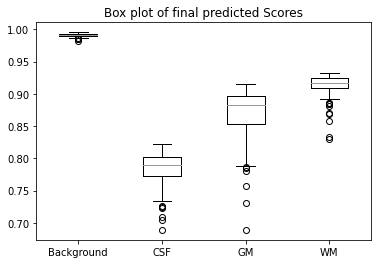

In [ ]:
fig1, ax1 = plt.subplots()
ax1.set_title('Box plot of final predicted Scores')
dic = ax1.boxplot(dice_test,labels=["Background","CSF","GM","WM"])

Computing Features: 100%|██████████| 100/100 [00:00<00:00, 429.67it/s]


MAE: 6.896875
R2: 0.8086010955129643


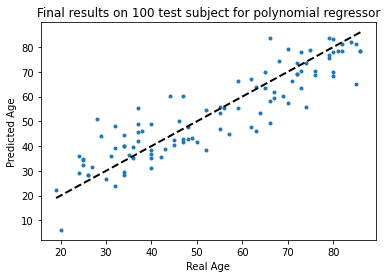

In [ ]:
ids_reg_test = list(meta_data_reg_test['subject_id'])
files_reg_seg_test = [seg_dir + 'sub-' + f + '_T1w_seg.nii.gz' for f in ids_reg_test]

# THIS MATRIX WILL STORE THE VOLUMES PER TISSUE CLASS
vols = np.zeros((3,len(files_reg_seg_test)))

for idx, _ in enumerate(tqdm(range(len(files_reg_seg_test)), desc='Computing Features')):
    
    seg_filename = files_reg_seg_test[idx]
    
    if os.path.exists(seg_filename):
        seg = sitk.ReadImage(seg_filename)
        seg_array = sitk.GetArrayFromImage(seg)
        for i in range(3):
            vols[i][idx] = np.sum(seg_array[seg_array==(i+1)]==i+1)


##Normalize
## CALCULATE RELATIVE TISSUE VOLUMES

vols_normalised = np.zeros((3,len(files_reg_seg_test)))

for idx in range(len(files_reg_seg_test)):
    brain_volume = np.sum(vols[:,idx])
    vols_normalised[:,idx] = vols[:,idx]/brain_volume

##Get features
X = vols_normalised.T
y = meta_data_reg_test['age'].values.reshape(-1,1)

#Make prediction with previously selected best regressor (fitted on 100% of train data)
predicted = regressor.predict(X)

print('MAE: {0}'.format(mean_absolute_error(y,predicted)))
print('R2: {0}'.format(r2_score(y,predicted)))

fig, ax = plt.subplots()
ax.scatter(y, predicted, marker='.')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Real Age')
ax.set_ylabel('Predicted Age')
ax.set_title("Final results on 100 test subject for polynomial regressor")
plt.show()

## Part B: Age prediction using regression CNNs

For the second approach we will use a convolutional neural network to directly predict a subject's age.

Implement a CNN model that takes an MRI scan as an input and maps it to a one-dimensional, real-valued output. A good starting point may be a LeNet-type architecture and adapt the last layers to convert the classification into a regression network. 

### Build Model

In [42]:
from ResNeXt import generate_model
model = generate_model(model_depth=50,
                                       cardinality=32,
                                       n_classes=1,
                                       n_input_channels=1,
                                       shortcut_type='B',
                                       conv1_t_size=7,
                                       conv1_t_stride=1,
                                       no_max_pool=True).to(device)

### Load Data

In [43]:
########################################
class ImageRegressionDataset(Dataset):
    """Dataset for age regression."""

    def __init__(self, file_list_img, file_list_msk, img_spacing, img_size):
        self.samples = []
        self.img_names = []
        for idx, _ in enumerate(tqdm(range(len(file_list_img)), desc='Loading Data')):
            img_path = file_list_img[idx]
            msk_path = file_list_msk[idx]

            img = sitk.ReadImage(img_path, sitk.sitkFloat32)
            msk = sitk.ReadImage(msk_path, sitk.sitkUInt8)

            #pre=processing
            img = zero_mean_unit_var(img, msk)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            msk = resample_image(msk, img_spacing, img_size, is_label=True)

            #pre=processing
            img = zero_mean_unit_var(img, msk)
            img = resample_image(img, img_spacing, img_size, is_label=False)
            img_name = os.path.basename(img_path)
            label = meta_data[meta_data['subject_id'] == img_name.split('_')[0][4:]].age.values[0]

            sample = {'img': img, 'label': label}

            self.samples.append(sample)
            self.img_names.append(img_name)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        sample = self.samples[item]

        image = torch.from_numpy(sitk.GetArrayFromImage(sample['img'])).unsqueeze(0)
        label = torch.tensor(sample['label']).unsqueeze(0)

        return {'img': image, 'label': label}

    def get_sample(self, item):
        return self.samples[item]

    def get_img_name(self, item):
        return self.img_names[item]

########################################

In [ ]:
rnd_seed = 42 #fixed random seed

img_size = [64, 64, 64]
img_spacing = [3, 3, 3]

num_epochs = 12
learning_rate = 1e-4
batch_size = 4
val_interval = 1

num_classes = 1

#out_dir = r'/content/drive/My Drive/ML_for_Imaging/output'
out_dir = './output'
# Create output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

meta_data_reg = pd.read_csv(data_dir + 'meta/meta_data_regression_train.csv')
ids_reg = list(meta_data_reg['subject_id'])
files_reg_img = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_reg]
files_reg_msk = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_reg]

meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_segmentation_train.csv')
ids_reg_test = list(meta_data_reg_test['subject_id'])
files_reg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_reg_test]
files_reg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_reg_test]

# LOAD TRAINING AND VALIDATION DATA
dataset_train = ImageRegressionDataset(files_reg_img, files_reg_msk, img_spacing, img_size)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# LOAD VALIDATION DATA
dataset_val = ImageRegressionDataset(files_reg_img_test, files_reg_msk_test, img_spacing, img_size)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

Loading Data: 100%|██████████| 47/47 [00:12<00:00,  3.85it/s]


### Train Model

In [ ]:
model_dir = os.path.join(out_dir, 'resnext3d_reg/')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.manual_seed(rnd_seed) #fix random seed

def train_model(model,dataloader_train,dataloader_val,num_epochs=12,save_model=False):
    model.train()
        
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    loss_train_log = []
    loss_val_log = []
    epoch_val_log = []
        
    print('START TRAINING...')
    for epoch in range(1, num_epochs + 1):

        # Training
        loss_train = 0
        for batch_idx, batch_samples in enumerate(tqdm(dataloader_train)):
            img, label = batch_samples['img'].to(device), batch_samples['label'].to(device)
            label = label.type(torch.FloatTensor).to(device)
            optimizer.zero_grad()
            prd = model(img)
            loss = F.mse_loss(prd, label)
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

        loss_train_log.append(loss_train/len(dataloader_train))

        print('+ TRAINING \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss_train/len(dataloader_train)))
        
        # Validation
        loss_val = 0
        sum_pts = 0
        with torch.no_grad():
            for data_sample in tqdm(dataloader_val):
                img, label = data_sample['img'].to(device), data_sample['label'].to(device)
                prd = model(img)
                loss_val += F.mse_loss(prd, label).item()

        loss_val_log.append(loss_val/len(dataloader_val))
        epoch_val_log.append(epoch)

        print('--------------------------------------------------')
        print('+ VALIDATE \tEpoch: {} \tLoss: {:.6f}'.format(epoch, loss_val/len(dataloader_val)))
        print('--------------------------------------------------')


        # print('MAE: {0}'.format(mean_absolute_error(true_age,pred_age)))
        # print('R2: {0}'.format(r2_score(true_age,pred_age)))

    print('\nFinished TRAINING.')
    if (save_model):
        print(f"Saving Model as {os.path.join(model_dir, 'model_2.pt')} ")
        torch.save(model.state_dict(), os.path.join(model_dir, 'model_2.pt'))

    plt.plot(range(1, num_epochs + 1), loss_train_log, c='r', label='train')
    plt.plot(epoch_val_log, loss_val_log, c='b', label='val')
    plt.legend(loc='upper right')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

    return model

train_model(model,dataloader_train,dataloader_val,num_epochs = 12,save_model=True)

### Cross validation

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

def eval_model(model,dataloader_test):
    model.eval()
    true_age = []
    pred_age = []
    with torch.no_grad():
        for data_sample in tqdm(dataloader_test):
            img, label = data_sample['img'].to(device), data_sample['label'].to(device)
            prd = model(img)
            if len(prd) > 1 :
                for i in range(len(prd)):
                    pred_age.append(prd.cpu().detach().numpy()[i][0])
                    true_age.append(label.cpu().detach().numpy()[i][0])
            else:
                 pred_age.append(prd.cpu())
                 true_age.append(label.cpu())

    return mean_absolute_error(true_age,pred_age),r2_score(true_age,pred_age),pred_age,true_age


  0%|          | 0/63 [00:00<?, ?it/s]

START TRAINING...



100%|██████████| 63/63 [01:17<00:00,  1.23s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

+ TRAINING 	Epoch: 1 	Loss: 1704.682754



100%|██████████| 12/12 [00:03<00:00,  3.49it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 665.790781
--------------------------------------------------



100%|██████████| 63/63 [01:20<00:00,  1.27s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

+ TRAINING 	Epoch: 2 	Loss: 510.836899



100%|██████████| 12/12 [00:03<00:00,  3.40it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

--------------------------------------------------
+ VALIDATE 	Epoch: 2 	Loss: 264.236149
--------------------------------------------------



100%|██████████| 63/63 [01:21<00:00,  1.29s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

+ TRAINING 	Epoch: 3 	Loss: 209.048054



100%|██████████| 12/12 [00:03<00:00,  3.35it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

--------------------------------------------------
+ VALIDATE 	Epoch: 3 	Loss: 151.008931
--------------------------------------------------



100%|██████████| 63/63 [01:21<00:00,  1.29s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

+ TRAINING 	Epoch: 4 	Loss: 138.205614



100%|██████████| 12/12 [00:03<00:00,  3.40it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

--------------------------------------------------
+ VALIDATE 	Epoch: 4 	Loss: 148.627083
--------------------------------------------------



100%|██████████| 63/63 [01:21<00:00,  1.29s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

+ TRAINING 	Epoch: 5 	Loss: 133.694442



100%|██████████| 12/12 [00:03<00:00,  3.38it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

--------------------------------------------------
+ VALIDATE 	Epoch: 5 	Loss: 195.542517
--------------------------------------------------



100%|██████████| 63/63 [01:21<00:00,  1.29s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

+ TRAINING 	Epoch: 6 	Loss: 127.432372



100%|██████████| 12/12 [00:03<00:00,  3.38it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

--------------------------------------------------
+ VALIDATE 	Epoch: 6 	Loss: 157.568291
--------------------------------------------------



100%|██████████| 63/63 [01:21<00:00,  1.29s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

+ TRAINING 	Epoch: 7 	Loss: 93.239902



100%|██████████| 12/12 [00:03<00:00,  3.38it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

--------------------------------------------------
+ VALIDATE 	Epoch: 7 	Loss: 232.227425
--------------------------------------------------



100%|██████████| 63/63 [01:21<00:00,  1.29s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

+ TRAINING 	Epoch: 8 	Loss: 131.272384



100%|██████████| 12/12 [00:03<00:00,  3.38it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

--------------------------------------------------
+ VALIDATE 	Epoch: 8 	Loss: 128.852844
--------------------------------------------------



100%|██████████| 63/63 [01:21<00:00,  1.29s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

+ TRAINING 	Epoch: 9 	Loss: 112.239391



100%|██████████| 12/12 [00:03<00:00,  3.35it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

--------------------------------------------------
+ VALIDATE 	Epoch: 9 	Loss: 194.122892
--------------------------------------------------



100%|██████████| 63/63 [01:21<00:00,  1.30s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

+ TRAINING 	Epoch: 10 	Loss: 101.205019



100%|██████████| 12/12 [00:03<00:00,  3.39it/s]

--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 199.999380
--------------------------------------------------

Finished TRAINING.


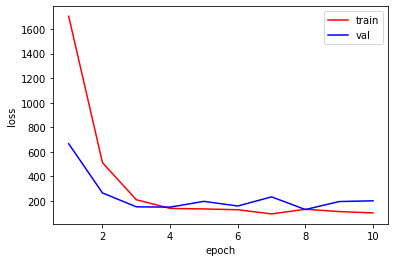


100%|██████████| 63/63 [00:17<00:00,  3.50it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

START TRAINING...



100%|██████████| 63/63 [01:21<00:00,  1.29s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

+ TRAINING 	Epoch: 1 	Loss: 1826.842468



100%|██████████| 12/12 [00:03<00:00,  3.39it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

--------------------------------------------------
+ VALIDATE 	Epoch: 1 	Loss: 688.812995
--------------------------------------------------



100%|██████████| 63/63 [01:21<00:00,  1.29s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

+ TRAINING 	Epoch: 2 	Loss: 574.104830



100%|██████████| 12/12 [00:03<00:00,  3.39it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

--------------------------------------------------
+ VALIDATE 	Epoch: 2 	Loss: 228.188215
--------------------------------------------------



100%|██████████| 63/63 [01:21<00:00,  1.29s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

+ TRAINING 	Epoch: 3 	Loss: 233.056498



100%|██████████| 12/12 [00:03<00:00,  3.37it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

--------------------------------------------------
+ VALIDATE 	Epoch: 3 	Loss: 215.005562
--------------------------------------------------



100%|██████████| 63/63 [01:21<00:00,  1.29s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

+ TRAINING 	Epoch: 4 	Loss: 151.157679



100%|██████████| 12/12 [00:03<00:00,  3.36it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

--------------------------------------------------
+ VALIDATE 	Epoch: 4 	Loss: 179.355862
--------------------------------------------------



100%|██████████| 63/63 [01:21<00:00,  1.29s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

+ TRAINING 	Epoch: 5 	Loss: 157.550662



100%|██████████| 12/12 [00:03<00:00,  3.36it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

--------------------------------------------------
+ VALIDATE 	Epoch: 5 	Loss: 173.157974
--------------------------------------------------



100%|██████████| 63/63 [01:21<00:00,  1.29s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

+ TRAINING 	Epoch: 6 	Loss: 112.341238



100%|██████████| 12/12 [00:03<00:00,  3.38it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

--------------------------------------------------
+ VALIDATE 	Epoch: 6 	Loss: 198.697086
--------------------------------------------------



100%|██████████| 63/63 [01:21<00:00,  1.29s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

+ TRAINING 	Epoch: 7 	Loss: 119.833257



100%|██████████| 12/12 [00:03<00:00,  3.35it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

--------------------------------------------------
+ VALIDATE 	Epoch: 7 	Loss: 159.357544
--------------------------------------------------



100%|██████████| 63/63 [01:21<00:00,  1.29s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

+ TRAINING 	Epoch: 8 	Loss: 98.459316



100%|██████████| 12/12 [00:03<00:00,  3.36it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

--------------------------------------------------
+ VALIDATE 	Epoch: 8 	Loss: 193.570821
--------------------------------------------------



100%|██████████| 63/63 [01:21<00:00,  1.29s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

+ TRAINING 	Epoch: 9 	Loss: 87.419527



100%|██████████| 12/12 [00:03<00:00,  3.36it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

--------------------------------------------------
+ VALIDATE 	Epoch: 9 	Loss: 139.510468
--------------------------------------------------



100%|██████████| 63/63 [01:21<00:00,  1.29s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

+ TRAINING 	Epoch: 10 	Loss: 88.211971



100%|██████████| 12/12 [00:03<00:00,  3.39it/s]

--------------------------------------------------
+ VALIDATE 	Epoch: 10 	Loss: 163.199889
--------------------------------------------------

Finished TRAINING.


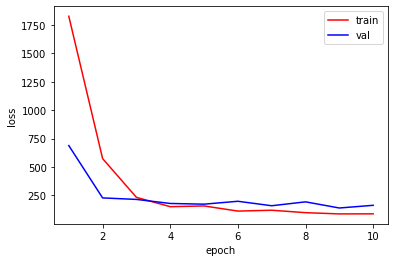


100%|██████████| 63/63 [00:17<00:00,  3.51it/s]

Average MAE across 2 folds : 10.636 
 Average r2 across 2folds : 0.471


In [ ]:
dataset_1,dataset_2 = torch.utils.data.random_split(dataset_train, [int(np.floor(0.5*len(dataset_train))), len(dataset_train) - int(np.floor(0.5*len(dataset_train)))]) #Cross Validation 2 fold

dataloader_1 = torch.utils.data.DataLoader(dataset_1, batch_size=batch_size, shuffle=True)
dataloader_2 = torch.utils.data.DataLoader(dataset_2, batch_size=batch_size, shuffle=True)

#build model
model = generate_model(model_depth=50,
                        cardinality=32,
                        n_classes=1,
                        n_input_channels=1,
                        shortcut_type='B',
                        conv1_t_size=7,
                        conv1_t_stride=1,
                        no_max_pool=True).to(device)

#train it on first dataset, evaluate on second
model = train_model(model,dataloader_1,dataloader_val,num_epochs=10)

MAE_1,r2_1,_,_ = eval_model(model,dataloader_2)

#Rebuild model
model = generate_model(model_depth=50,
                        cardinality=32,
                        n_classes=1,
                        n_input_channels=1,
                        shortcut_type='B',
                        conv1_t_size=7,
                        conv1_t_stride=1,
                        no_max_pool=True).to(device)


#train it on second dataset, evaluate on first
model = train_model(model,dataloader_2,dataloader_val,num_epochs=10)

MAE_2,r2_2,_,_ = eval_model(model,dataloader_1)


print(f'Average MAE across 2 folds : {(MAE_1 + MAE_2)/2:.3f} \n Average r2 across 2folds : {(r2_1 + r2_2)/2:.3f}')


### Final Test 

#### Downloading data

In [ ]:
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-testdata.zip
! unzip brainage-testdata.zip

--2021-03-03 15:25:56--  https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/brainage-testdata.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1521 (1.5K) [application/zip]
Saving to: ‘brainage-testdata.zip.1’

brainage-testdata.z 100%[===================>]   1.49K  --.-KB/s    in 0s      

2021-03-03 15:25:56 (308 MB/s) - ‘brainage-testdata.zip.1’ saved [1521/1521]

Archive:  brainage-testdata.zip
replace data/brain_age/meta/meta_data_regression_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

#### Loading and preprocessing

In [ ]:
meta_data_reg_test = pd.read_csv(data_dir + 'meta/meta_data_regression_test.csv')
ids_seg_test = list(meta_data_reg_test['subject_id'])
files_reg_img_test = [data_dir + 'images/sub-' + f + '_T1w_unbiased.nii.gz' for f in ids_seg_test]
files_reg_msk_test = [data_dir + 'masks/sub-' + f + '_T1w_brain_mask.nii.gz' for f in ids_seg_test]

dataset_test = ImageRegressionDataset(files_reg_img_test, files_reg_msk_test, img_spacing, img_size)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)


Loading Data: 100%|██████████| 100/100 [00:26<00:00,  3.71it/s]


#### Run final testing

In [ ]:
#Prior to this, one should run the cell to train and save the model
model = generate_model(model_depth=50,
                        cardinality=32,
                        n_classes=1,
                        n_input_channels=1,
                        shortcut_type='B',
                        conv1_t_size=7,
                        conv1_t_stride=1,
                        no_max_pool=True).to(device)


model_dir = os.path.join(out_dir, 'resnext3d_reg/')
model.load_state_dict(torch.load(model_dir + 'model_2.pt'))


# Test
MAE,r2,pred_age,true_age = eval_model(model,dataloader_test)


100%|██████████| 100/100 [00:07<00:00, 12.95it/s]


MAE: 7.087340068817139
R2: 0.7982849366211365


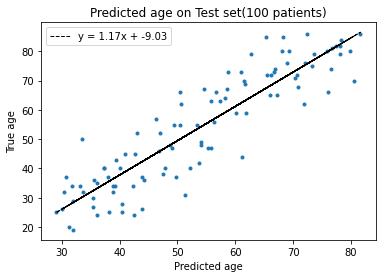

In [ ]:
plt.figure()
plt.scatter(pred_age,true_age,marker = '.')

m, b = np.polyfit(pred_age, true_age, 1)
plt.plot(pred_age, m*np.array(pred_age) + b, 'k--', label = 'y = '+str(round(m,3)) + 'x + ' + str(round(b,3)), lw=1)
plt.title('Predicted age on Test set(100 patients)')
plt.xlabel('Predicted age')
plt.ylabel('True age')
plt.legend()

print('MAE: {0}'.format(MAE))
print('R2: {0}'.format(r2))